In [16]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
data = pd.read_csv("kc_house_data.csv")

In [18]:
data.shape

(21613, 21)

In [19]:
pd.options.display.max_columns = 25

In [20]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [21]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [22]:
# STEP03 資料前處理 : pdf.72
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

data.drop(['id'], axis ="columns", inplace = True)
data.drop(['date'], axis ="columns", inplace = True)

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [26]:
#=== 分割資料 ===
# shape[0] -> 返回行數; shape[1] -> 返回列數
data_num = data.shape[0] 

# 取得一筆與data數量相同的亂數索引(隨機排序)，主要目的是用於打散資料
indexes = np.random.permutation(data_num)

# 亂數索引值分為Train, Valiadation & Test，比例 = 6:2:2
train_indexes = indexes[:int(data_num * 0.6)]
val_indexes = indexes[int(data_num * 0.6) : int(data_num * 0.8)]
test_indexes = indexes[int(data_num * 0.8):]

# 透過索引值從data取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

In [28]:
# STEP04 標準化 pdf.73
"""
將不同的資料縮放到相同大小。
通常會將輸入資料縮放到0 ~ 1 or -1 ~ 1之間，這個過程稱之「資料標準化」(Data Normalization)
本範例使用「標準分數」(Standard Score, z-score)來將資料標準化
經過z-score標準化後的資料，都會聚集在0附近且標準差為1
"""
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean()
std = train_validation_data.std()
train_data = (train_data - mean) / std
val_data = (val_data - mean) / std


In [29]:
# STEP05 建立Numpy array 格式的訓練資料 pdf.73
# drop's attr. "axis" value incl. : 0, 1, 'index', 'columns'
x_train = np.array(train_data.drop('price', axis = 'columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis = 'columns'))
y_val = np.array(val_data['price'])

x_train.shape

(12967, 21)

In [34]:
# STEP06 建立並訓練網路模型 : use ReLU as hidden layer's activation function
model = keras.Sequential(name='model-1')
model.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.summary()



Model: "model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1408      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 設定訓練使用的優化器、損失函數和指標函數
model.compile(keras.optimizers.Adam(0.001),
             loss = keras.losses.MeanSquaredError(),
             metrics = [keras.metrics.MeanAbsoluteError()])
# 建立模型儲存目錄
model_dir = 'lab2-logs/models/'
os.makedirs(model_dir)
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + 'Best-model-1.h5',
                                            monitor = 'val_mean_absolute_error',
                                            save_best_only = True,
                                            mode = 'min')
# 訓練網路模型
history = model.fit(x_train, y_train,
                   batch_size = 64,
                   epochs = 300,
                   validation_data = (x_val, y_val),
                   callbacks = [model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 3s 10ms/step - loss: 0.3279 - mean_absolute_error: 0.3509 - val_loss: 0.2701 - val_mean_absolute_error: 0.3103
Epoch 2/300
203/203 [==============================] - 2s 8ms/step - loss: 0.1961 - mean_absolute_error: 0.2775 - val_loss: 0.2282 - val_mean_absolute_error: 0.2763
Epoch 3/300
203/203 [==============================] - 2s 8ms/step - loss: 0.1680 - mean_absolute_error: 0.2556 - val_loss: 0.2069 - val_mean_absolute_error: 0.2752
Epoch 4/300
203/203 [==============================] - 2s 9ms/step - loss: 0.1552 - mean_absolute_error: 0.2445 - val_loss: 0.1870 - val_mean_absolute_error: 0.2516
Epoch 5/300
203/203 [==============================] - 2s 10ms/step - loss: 0.1378 - mean_absolute_error: 0.2310 - val_loss: 0.1861 - val_mean_absolute_error: 0.2440
Epoch 6/300
203/203 [==============================] - 2s 10ms/step - loss: 0.1330 - mean_absolute_error: 0.2248 - val_loss: 0.1707 - val_mean_absolute_error: 0.2365
Epoch 7

203/203 [==============================] - 1s 5ms/step - loss: 0.0570 - mean_absolute_error: 0.1610 - val_loss: 0.1237 - val_mean_absolute_error: 0.2047
Epoch 51/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0559 - mean_absolute_error: 0.1597 - val_loss: 0.1289 - val_mean_absolute_error: 0.2101
Epoch 52/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0544 - mean_absolute_error: 0.1589 - val_loss: 0.1244 - val_mean_absolute_error: 0.2079
Epoch 53/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0537 - mean_absolute_error: 0.1589 - val_loss: 0.1306 - val_mean_absolute_error: 0.2103
Epoch 54/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0548 - mean_absolute_error: 0.1600 - val_loss: 0.1235 - val_mean_absolute_error: 0.2082
Epoch 55/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0534 - mean_absolute_error: 0.1588 - val_loss: 0.1249 - val_mean_absolute_error: 0.2085
Epoch 56/300
203/

203/203 [==============================] - 1s 5ms/step - loss: 0.0391 - mean_absolute_error: 0.1414 - val_loss: 0.1346 - val_mean_absolute_error: 0.2161
Epoch 100/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0394 - mean_absolute_error: 0.1410 - val_loss: 0.1356 - val_mean_absolute_error: 0.2133
Epoch 101/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0387 - mean_absolute_error: 0.1412 - val_loss: 0.1350 - val_mean_absolute_error: 0.2150
Epoch 102/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0404 - mean_absolute_error: 0.1432 - val_loss: 0.1471 - val_mean_absolute_error: 0.2192
Epoch 103/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0420 - mean_absolute_error: 0.1436 - val_loss: 0.1410 - val_mean_absolute_error: 0.2186
Epoch 104/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0388 - mean_absolute_error: 0.1404 - val_loss: 0.1336 - val_mean_absolute_error: 0.2128
Epoch 105/30

203/203 [==============================] - 1s 5ms/step - loss: 0.0345 - mean_absolute_error: 0.1339 - val_loss: 0.1367 - val_mean_absolute_error: 0.2158
Epoch 149/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0330 - mean_absolute_error: 0.1312 - val_loss: 0.1409 - val_mean_absolute_error: 0.2177
Epoch 150/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0331 - mean_absolute_error: 0.1318 - val_loss: 0.1409 - val_mean_absolute_error: 0.2169
Epoch 151/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0340 - mean_absolute_error: 0.1339 - val_loss: 0.1409 - val_mean_absolute_error: 0.2193
Epoch 152/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0318 - mean_absolute_error: 0.1308 - val_loss: 0.1419 - val_mean_absolute_error: 0.2168
Epoch 153/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0343 - mean_absolute_error: 0.1348 - val_loss: 0.1429 - val_mean_absolute_error: 0.2214
Epoch 154/30

203/203 [==============================] - 1s 5ms/step - loss: 0.0329 - mean_absolute_error: 0.1302 - val_loss: 0.1417 - val_mean_absolute_error: 0.2165
Epoch 198/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0280 - mean_absolute_error: 0.1232 - val_loss: 0.1434 - val_mean_absolute_error: 0.2146
Epoch 199/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0279 - mean_absolute_error: 0.1235 - val_loss: 0.1455 - val_mean_absolute_error: 0.2189
Epoch 200/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0282 - mean_absolute_error: 0.1237 - val_loss: 0.1472 - val_mean_absolute_error: 0.2193
Epoch 201/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0287 - mean_absolute_error: 0.1243 - val_loss: 0.1379 - val_mean_absolute_error: 0.2163
Epoch 202/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0295 - mean_absolute_error: 0.1261 - val_loss: 0.1436 - val_mean_absolute_error: 0.2184
Epoch 203/30

203/203 [==============================] - 1s 5ms/step - loss: 0.0273 - mean_absolute_error: 0.1217 - val_loss: 0.1466 - val_mean_absolute_error: 0.2187
Epoch 247/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0259 - mean_absolute_error: 0.1195 - val_loss: 0.1453 - val_mean_absolute_error: 0.2203
Epoch 248/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0280 - mean_absolute_error: 0.1236 - val_loss: 0.1423 - val_mean_absolute_error: 0.2157
Epoch 249/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0289 - mean_absolute_error: 0.1236 - val_loss: 0.1522 - val_mean_absolute_error: 0.2230
Epoch 250/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0294 - mean_absolute_error: 0.1252 - val_loss: 0.1444 - val_mean_absolute_error: 0.2211
Epoch 251/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0258 - mean_absolute_error: 0.1191 - val_loss: 0.1501 - val_mean_absolute_error: 0.2192
Epoch 252/30

203/203 [==============================] - 1s 5ms/step - loss: 0.0253 - mean_absolute_error: 0.1175 - val_loss: 0.1513 - val_mean_absolute_error: 0.2246
Epoch 296/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0266 - mean_absolute_error: 0.1202 - val_loss: 0.1462 - val_mean_absolute_error: 0.2231
Epoch 297/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0276 - mean_absolute_error: 0.1211 - val_loss: 0.1518 - val_mean_absolute_error: 0.2238
Epoch 298/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0248 - mean_absolute_error: 0.1176 - val_loss: 0.1501 - val_mean_absolute_error: 0.2239
Epoch 299/300
203/203 [==============================] - 1s 4ms/step - loss: 0.0239 - mean_absolute_error: 0.1156 - val_loss: 0.1510 - val_mean_absolute_error: 0.2254
Epoch 300/300
203/203 [==============================] - 1s 5ms/step - loss: 0.0245 - mean_absolute_error: 0.1173 - val_loss: 0.1510 - val_mean_absolute_error: 0.2264


In [37]:
# 歷史紀錄
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

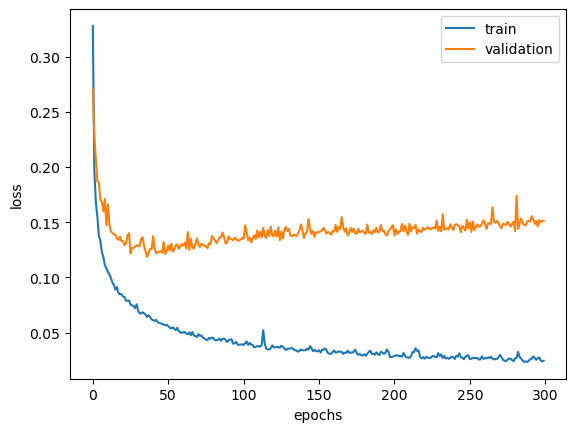

In [38]:
# 繪製損失值的折線圖
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

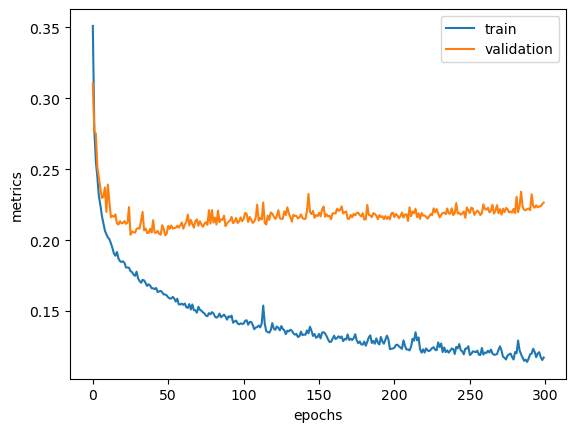

In [39]:
# 繪製效能指標的折線圖
plt.plot(history.history['mean_absolute_error'], label = 'train')
plt.plot(history.history['val_mean_absolute_error'], label = 'validation')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [42]:
# 測試資料的誤差百分比
model.load_weights('lab2-logs/models/Best-model-1.h5')
y_test = np.array(test_data['price'])
test_data = (test_data - mean) / std
x_test = np.array(test_data.drop('price', axis = 'columns'))
y_pred =model.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

136/136 [==============================] - 0s 1ms/step
Model_1 Percentage Error: 98.52%


In [47]:
# For test 
"""
x_train = np.array(train_data.drop('price', axis = 'columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis = 'columns'))
y_val = np.array(val_data['price'])
"""
print(train_data)
print("===")
print(y_train)

          price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
16007 -0.095006 -0.390073   0.507779    -0.090635 -0.335462  2.792275   
745    0.053527  0.679611   0.507779     0.933129 -0.225218  0.940682   
12314 -0.878183  1.749295  -0.789189    -0.106885 -0.177431  0.014886   
17170  0.242570  0.679611  -0.140705     0.640625 -0.292580  0.014886   
15367  0.296582  0.679611  -0.789189     0.434789 -0.215871 -0.910911   
...         ...       ...        ...          ...       ...       ...   
7573  -0.594619 -0.390073  -0.464947    -0.648559 -0.195321 -0.910911   
9879   3.234845  0.679611   0.183537     0.911462 -0.212698  0.940682   
7864  -0.689140 -1.459757  -1.437673    -1.114399 -0.296290 -0.910911   
1833   0.067030  1.749295   1.804747     0.673125 -0.086713  0.014886   
13305 -0.729649 -1.459757  -1.437673    -0.020217 -0.166692 -0.910911   

       waterfront      view  condition     grade  sqft_above  sqft_basement  \
16007   -0.086698 -0.304853  -0.632987  0.29